# Exploratory Data Analysis (EDA): Hands-On


# 0. Business Understanding

Given opportunity areas in the automation industry, this notebook aims to implement an EDA based on a production line case scenery to detect defective materials, thus optimizing error detection to reduce costs and risks.

# 1. Data Collection

First of, the work area set up requires some core libraries import to access, manipulate, and visualize the data:

In [57]:
# Required Libraries for the dataframes and directories
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from matplotlib import colormaps
from matplotlib.dates import DateFormatter
from scipy import stats
import os
import random

To work locally, retrival of the base data for the case study is set through the Google Drive unit and active directory:

In [3]:
# Current directory, and unzipping of the dataframes
curdur = os.getcwd()
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/Programming/Reddis & Python/SourceData')
!unzip '/content/drive/MyDrive/Colab Notebooks/Programming/Reddis & Python/SourceData/test_numeric.csv.zip'
!unzip '/content/drive/MyDrive/Colab Notebooks/Programming/Reddis & Python/SourceData/test_categorical.csv.zip'
!unzip '/content/drive/MyDrive/Colab Notebooks/Programming/Reddis & Python/SourceData/test_date.csv.zip'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/Colab Notebooks/Programming/Reddis & Python/SourceData/test_numeric.csv.zip
  inflating: test_numeric.csv        
Archive:  /content/drive/MyDrive/Colab Notebooks/Programming/Reddis & Python/SourceData/test_categorical.csv.zip
replace test_categorical.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test_categorical.csv    
Archive:  /content/drive/MyDrive/Colab Notebooks/Programming/Reddis & Python/SourceData/test_date.csv.zip
  inflating: test_date.csv           


The sample data taken from the [Bosch Challenge](https://www.kaggle.com/c/bosch-production-line-performance/data) is large enough to be dived in several files, exceeding storage quotes easily, thus base data resizing is performed to avoid an overload of the notebook capabilities whilst in the exploring stage of the data structures:

In [4]:
# Pre-subsetting of the dataframes

# Desired sample size
s = 10

# Number of records in the file without header
n = sum(1 for line in open('test_numeric.csv')) - 1
skip = sorted(random.sample(range(1,n+1),n-s))
testNumeric = pd.read_csv('test_numeric.csv', skiprows=skip)

n = sum(1 for line in open('test_categorical.csv')) - 1
skip = sorted(random.sample(range(1,n+1),n-s))
testCategorical = pd.read_csv('test_categorical.csv', skiprows=skip)

n = sum(1 for line in open('test_date.csv')) - 1
skip = sorted(random.sample(range(1,n+1),n-s))
testDate = pd.read_csv('test_date.csv', skiprows=skip)

NOTE. Given the data specifications, and after further analysis a [production quality](https://www.kaggle.com/datasets/podsyp/production-quality?resource=download) dataset was used as starting point to generate mockup data with the [Mockaroo API](https://www.mockaroo.com/), thus generating a control point for product quality within the production line:

In [5]:
# Loading the production quality dataframe
MockDF = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Programming/Reddis & Python/SourceData/MOCK_DATA.csv')

Up to this point, public data was collected from the main source based on the business understanding, and after iterating through the steps of data analysis, another set of data was introduced as a control point for product quality within the production line.

# 2. Data Exploration

To grasp a quick understanding of the main source data the method `.info()` is called to get a summary:



In [6]:
#  Bosch data summary:
print(testNumeric.info(),  testCategorical.info(), testDate.info(), end ='\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Columns: 969 entries, Id to L3_S51_F4262
dtypes: float64(968), int64(1)
memory usage: 75.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Columns: 2141 entries, Id to L3_S49_F4240
dtypes: float64(2051), int64(1), object(89)
memory usage: 167.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Columns: 1157 entries, Id to L3_S51_D4263
dtypes: float64(1156), int64(1)
memory usage: 90.5 KB
None None None


Given that the Bosch data set contained missing values in each record, to avoid skewing the data it was considered to base the column values in a reference dataset for production quality (which was the one added as a note in the previous); thus, the use of a randomly generated dataset based on said thought process:

In [7]:
# Summary of the control data:
print(MockDF.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   L0_S0_F1   1000 non-null   int64  
 2   L0_S0_F2   1000 non-null   int64  
 3   L0_S0_F3   1000 non-null   int64  
 4   L0_S0_D4   1000 non-null   object 
 5   L1_S0_F5   1000 non-null   int64  
 6   L1_S0_F6   1000 non-null   int64  
 7   L1_S0_F7   1000 non-null   int64  
 8   L1_S0_D8   1000 non-null   object 
 9   L2_S0_F9   1000 non-null   int64  
 10  L2_S0_F10  1000 non-null   int64  
 11  L2_S0_F11  1000 non-null   int64  
 12  L2_S0_D12  1000 non-null   object 
 13  L3_S0_F13  1000 non-null   int64  
 14  L3_S0_F14  1000 non-null   int64  
 15  L3_S0_F15  1000 non-null   int64  
 16  L3_S0_D16  1000 non-null   object 
 17  H_Data     1000 non-null   float64
 18  AH_Data    1000 non-null   float64
dtypes: float64(2), int64(13), object(4)
memory usage:

A glimpse into the data can help to identify data structures to evaluate the reshaping of the dataset, perform early quality control and sanitization of the data by detecting missing values or NAs, and formulate the possible use of the data and its representation.

# 3. Data Cleaning



Given the approach taken in the previous step, no data cleaning is necessary. In case that the dataframe selected to analyze had any missing values and NAs, their removal could be completed by:

In [8]:
# Removing NA and missing values
testNumeric = testNumeric.dropna(axis=0)
testCategorical = testCategorical.dropna(axis=0)
testDate = testDate.dropna(axis=0)

# Reviewing the names of the columns
print(testNumeric.columns, testCategorical.columns, testDate.columns, end ='\n')



Index(['Id', 'L0_S0_F0', 'L0_S0_F2', 'L0_S0_F4', 'L0_S0_F6', 'L0_S0_F8',
       'L0_S0_F10', 'L0_S0_F12', 'L0_S0_F14', 'L0_S0_F16',
       ...
       'L3_S50_F4243', 'L3_S50_F4245', 'L3_S50_F4247', 'L3_S50_F4249',
       'L3_S50_F4251', 'L3_S50_F4253', 'L3_S51_F4256', 'L3_S51_F4258',
       'L3_S51_F4260', 'L3_S51_F4262'],
      dtype='object', length=969) Index(['Id', 'L0_S1_F25', 'L0_S1_F27', 'L0_S1_F29', 'L0_S1_F31', 'L0_S2_F33',
       'L0_S2_F35', 'L0_S2_F37', 'L0_S2_F39', 'L0_S2_F41',
       ...
       'L3_S49_F4225', 'L3_S49_F4227', 'L3_S49_F4229', 'L3_S49_F4230',
       'L3_S49_F4232', 'L3_S49_F4234', 'L3_S49_F4235', 'L3_S49_F4237',
       'L3_S49_F4239', 'L3_S49_F4240'],
      dtype='object', length=2141) Index(['Id', 'L0_S0_D1', 'L0_S0_D3', 'L0_S0_D5', 'L0_S0_D7', 'L0_S0_D9',
       'L0_S0_D11', 'L0_S0_D13', 'L0_S0_D15', 'L0_S0_D17',
       ...
       'L3_S50_D4246', 'L3_S50_D4248', 'L3_S50_D4250', 'L3_S50_D4252',
       'L3_S50_D4254', 'L3_S51_D4255', 'L3_S51_D4257', 'L3_S51

To corroborate that the control data doesn´t have any missing values, their identification can be accounted by:

In [137]:
# Missing values
missing_values = MockDF.isnull().sum()
print(np.where(pd.isnull(MockDF)))

# NaN values
nan_values = MockDF[MockDF.isna().any(axis=1)]
print(nan_values)


(array([], dtype=int64), array([], dtype=int64))
Empty DataFrame
Columns: [ID, L0_S0_F1, L0_S0_F2, L0_S0_F3, L0_S0_D4, L1_S0_F5, L1_S0_F6, L1_S0_F7, L1_S0_D8, L2_S0_F9, L2_S0_F10, L2_S0_F11, L2_S0_D12, L3_S0_F13, L3_S0_F14, L3_S0_F15, L3_S0_D16, H_Data, AH_Data]
Index: []


Is worth nothing that a messy data set can take most of
the time on the EDA, so early sanitization practices of the data from the collection to the cleaning can optimize the time dedidated to it, and improve the quality of the analysis.

# 4. Data Analysis

For data analysis, the more accurate information that can be obtained from the data the better; a quick glimpse into the data could be obtained by looking at its statistics:

In [10]:
# Basic Statistics
print(MockDF.describe())

                ID    L0_S0_F1     L0_S0_F2     L0_S0_F3     L1_S0_F5  \
count  1000.000000  1000.00000  1000.000000  1000.000000  1000.000000   
mean    500.500000    -2.88700    -4.647000   -26.140000     5.253000   
std     288.819436   652.84395   621.749302   631.751724   613.747592   
min       1.000000  -987.00000  -987.000000  -987.000000 -1000.000000   
25%     250.750000  -678.00000  -567.000000  -678.000000  -543.000000   
50%     500.500000   123.00000  -123.000000   -12.000000     0.000000   
75%     750.250000   678.00000   567.000000   567.000000   543.000000   
max    1000.000000   901.00000   987.000000   901.000000  1000.000000   

          L1_S0_F6     L1_S0_F7    L2_S0_F9    L2_S0_F10    L2_S0_F11  \
count  1000.000000  1000.000000  1000.00000  1000.000000  1000.000000   
mean    -10.707000   -27.991000   -50.24400   -23.151000   -52.389000   
std     648.480058   669.795785   640.98943   653.990703   630.089743   
min    -987.000000  -901.000000  -987.00000  -987.

From the statistics above, it is confirmed that the dataset for the product quality is consistent of numerical data types; although the dataset was free of null, missing values or NAs is still posible for it to be skewed and far from a normal distribution, so detecting the outliers can help to determine if is normalized or needs to be adjusted:

In [11]:
# Z-score per record
Score = np.abs(stats.zscore(MockDF['AH_Data']))
# print(max(Score))

# Outliers  with a z-score greater than 1.72
outliers = MockDF[Score > 1.72]
print(outliers)

      ID  L0_S0_F1  L0_S0_F2  L0_S0_F3    L0_S0_D4  L1_S0_F5  L1_S0_F6  \
312  313       123       987       678   6/23/2023       987      -678   
553  554      -456      -456      -456   4/19/2023      -456      -890   
934  935      -678       789       789  12/29/2023      1000       678   

     L1_S0_F7    L1_S0_D8  L2_S0_F9  L2_S0_F10  L2_S0_F11   L2_S0_D12  \
312      -654  11/15/2023       678       -123        654  12/23/2023   
553       345   11/6/2023      -901       -678        567   5/27/2023   
934      -789   9/22/2023      -456        678        890  11/23/2023   

     L3_S0_F13  L3_S0_F14  L3_S0_F15  L3_S0_D16  H_Data  AH_Data  
312       -567       -852       -123  5/23/2023  166.12    10.99  
553       -543        693       -789  1/16/2024  189.85    10.96  
934        123        123       -789  3/30/2023  204.87    10.95  


Outliers can be dropped from the data or transformed, since the dataset was sanitized previously and is majorly consistent, in this case the outliers are to be replaced with the median value; thus, improving the accuracy and reliability of the analysis:

In [12]:
# Outliers replacement by the median value
MockDF.loc[Score > 1.72, 'AH_Data'] = MockDF['AH_Data'].median()

The data can be grouped by a correlating factor or category of interest for the analysis, for example grouping it to evaluate the 'Raw Material Humidity':

In [13]:
# Numeric Categorical Analysis by Data aggrupation
GroupedData = MockDF.groupby('AH_Data').mean()
GroupedData

<ipython-input-13-8cef834aab6c>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  GroupedData = MockDF.groupby('AH_Data').mean()


,ID,L0_S0_F1,L0_S0_F2,L0_S0_F3,L1_S0_F5,L1_S0_F6,L1_S0_F7,L2_S0_F9,L2_S0_F10,L2_S0_F11,L3_S0_F13,L3_S0_F14,L3_S0_F15,H_Data
AH_Data,,,,,,,,,,,,,,
2.00,381.00,-678.00,876.0,-567.0,-876.00,-567.000000,-901.00,-987.00,-901.0,-654.0,789.0,-159.00,-901.0,152.790000
2.01,495.75,-15.75,210.0,-25.0,-165.75,0.000000,-693.75,-255.75,55.5,-327.0,154.5,360.75,-111.0,160.837500
2.02,133.00,-234.00,-789.0,-345.0,987.00,890.000000,123.00,-789.00,-987.0,789.0,789.0,693.00,-456.0,176.640000
2.08,211.50,456.00,499.5,-333.0,-28.00,-511.500000,-789.00,-328.00,167.0,610.5,931.5,73.50,-333.5,190.565000
2.11,426.00,-678.00,321.0,345.0,-789.00,-678.000000,-901.00,-678.00,-456.0,-890.0,-567.0,123.00,-890.0,206.320000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10.86,384.00,152.00,181.0,115.0,-78.00,748.666667,765.00,152.00,-641.0,-255.0,-78.0,366.00,115.0,161.976667
10.87,172.50,-111.00,-123.0,-48.5,-55.50,-43.000000,456.00,-166.50,839.5,123.0,-123.0,-330.00,456.0,201.285000
10.88,471.00,166.50,-67.5,0.0,-900.00,-734.000000,-55.50,-222.00,-56.0,265.5,277.5,451.50,-389.0,176.085000


Once the data is grouped is easier for Python to suggest plots to analize the behavior of the data, such as barplots, histograms, scatterplots, and line plots; code that can be copied and pasted in the notebook, or added automatically. Given the suggestions above, a histogram for 50 of the records per each feature is constructed:

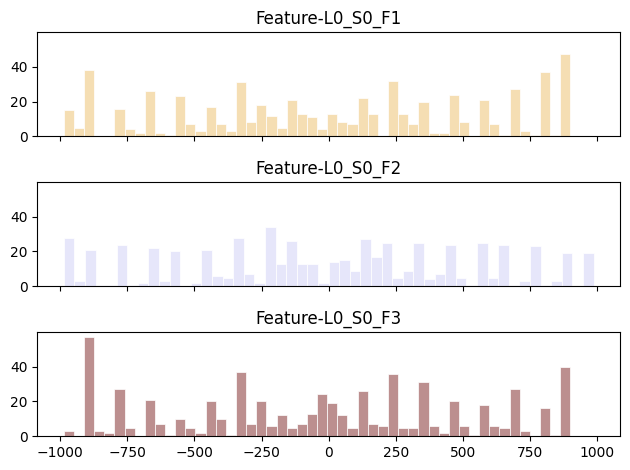

In [15]:
# Subplot function using number of rows and columns
figure, (ax0, ax1, ax2) = plt.subplots(3, sharex=True, sharey=True)

# Histogram plot per feature
ax0.hist(GroupedData['L0_S0_F1'], bins=50, linewidth=0.5, color='wheat', edgecolor="white")
ax0.set_title("Feature-L0_S0_F1")

ax1.hist(GroupedData['L0_S0_F2'], bins=50, linewidth=0.5, color='lavender', edgecolor="white")
ax1.set_title("Feature-L0_S0_F2")

ax2.hist(GroupedData['L0_S0_F3'], bins=50, linewidth=0.5, color='rosybrown', edgecolor="white")
ax2.set_title("Feature-L0_S0_F3")

# Combination of plots and display
figure.tight_layout()
plt.show()

High negative values can be seen on display across the features; although given the fact that they represent a sensor in a chamber and raw materials undergo a cooling and heating process, the meassures align visibly with said behavior, and the one of the production quality data they are based on. Next, subplots of each feature were called upon a scatter plot to deepen the understanding of their data distribution:

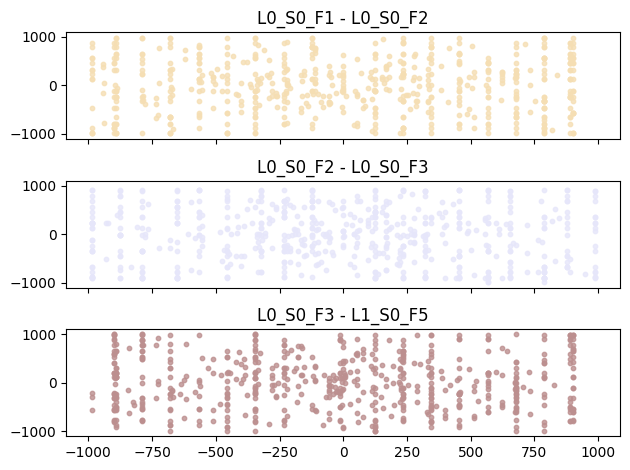

In [16]:
# Subplot function using number of rows and columns
figure, axis = plt.subplots(3, sharex=True, sharey=True)

# Scatterplot plot per feature
axis[0].scatter(x= GroupedData.L0_S0_F1, y= GroupedData.L0_S0_F2, s=10, alpha=.8, color='wheat')
axis[0].set_title("L0_S0_F1 - L0_S0_F2")

axis[1].scatter(x= GroupedData.L0_S0_F2, y= GroupedData.L0_S0_F3, s=10, alpha=.8, color='lavender')
axis[1].set_title("L0_S0_F2 - L0_S0_F3")

axis[2].scatter(x= GroupedData.L0_S0_F3, y= GroupedData.L1_S0_F5, s=10, alpha=.8, color='rosybrown')
axis[2].set_title("L0_S0_F3 - L1_S0_F5")

# Combination of plots and display
figure.tight_layout()
plt.show()

The resulting plot showing the advantages of the data sanitization and normalization process for the data distribution. Lastly, the features were analyzed over time with a line plot:

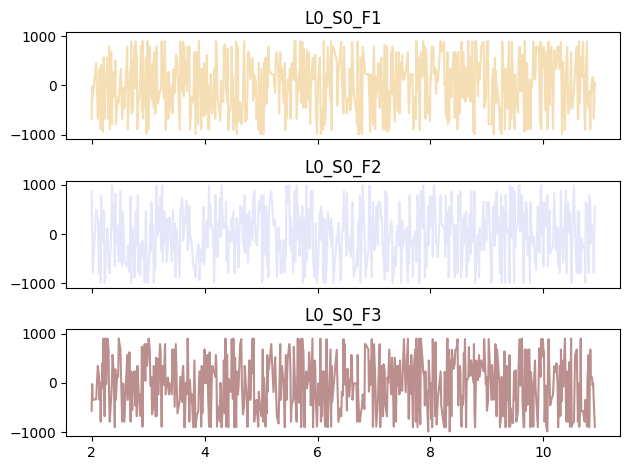

In [17]:
# Subplot of values
figure, axis = plt.subplots(3, sharex=True, sharey=True)

# Plot features values
axis[0].plot(GroupedData.L0_S0_F1, color='wheat')
axis[0].set_title("L0_S0_F1")

axis[1].plot(GroupedData.L0_S0_F2, color='lavender')
axis[1].set_title("L0_S0_F2")

axis[2].plot(GroupedData.L0_S0_F3, color='rosybrown')
axis[2].set_title("L0_S0_F3")

# Combination of plots and display
figure.tight_layout()
plt.show()

By now, the mock data aligns with the behavior of the indexes corresponding to the sensor data for production quality, it has been normalized and properly reshaped for its visualization.

# 5. Data Visualization

Whilst data analysis can be done through a series of statistical an mathematical methods, Python provides an automatic generation of a sample report for EDA, with `ydata-profiling`:

In [18]:
# Pip installation of ydata-profiling:
!pip install ydata-profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.8/357.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 32.1 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=25222a0043fb131e34df12322095c92818c0169cfe6588addfcb3f235c3ddc15
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1


Once the [package](https://github.com/ydataai/ydata-profiling) is properly installed in the environment, the `ProfileReport`can be imported from it to construct a basic EDA report and save it as an .htlm file which is the equivalent to a dashboard to present the data analytics:

In [19]:
# Import of the new installed package
from ydata_profiling import ProfileReport
# Base configuration of the auto EDA report
report = ProfileReport(MockDF, title = "Sample Report", html={'style' : {'full_width':True}})
report.to_file(output_file="Sample Report.html")
report

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:354: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

If not visible due to the size of the file, the report is stored automatically in the directory with the source data, thus it can be consulted anytime and be downloaded at once. Asides from providing detailed information of the variables,interactions, correlations, and missing values, it gives an overview of the data:

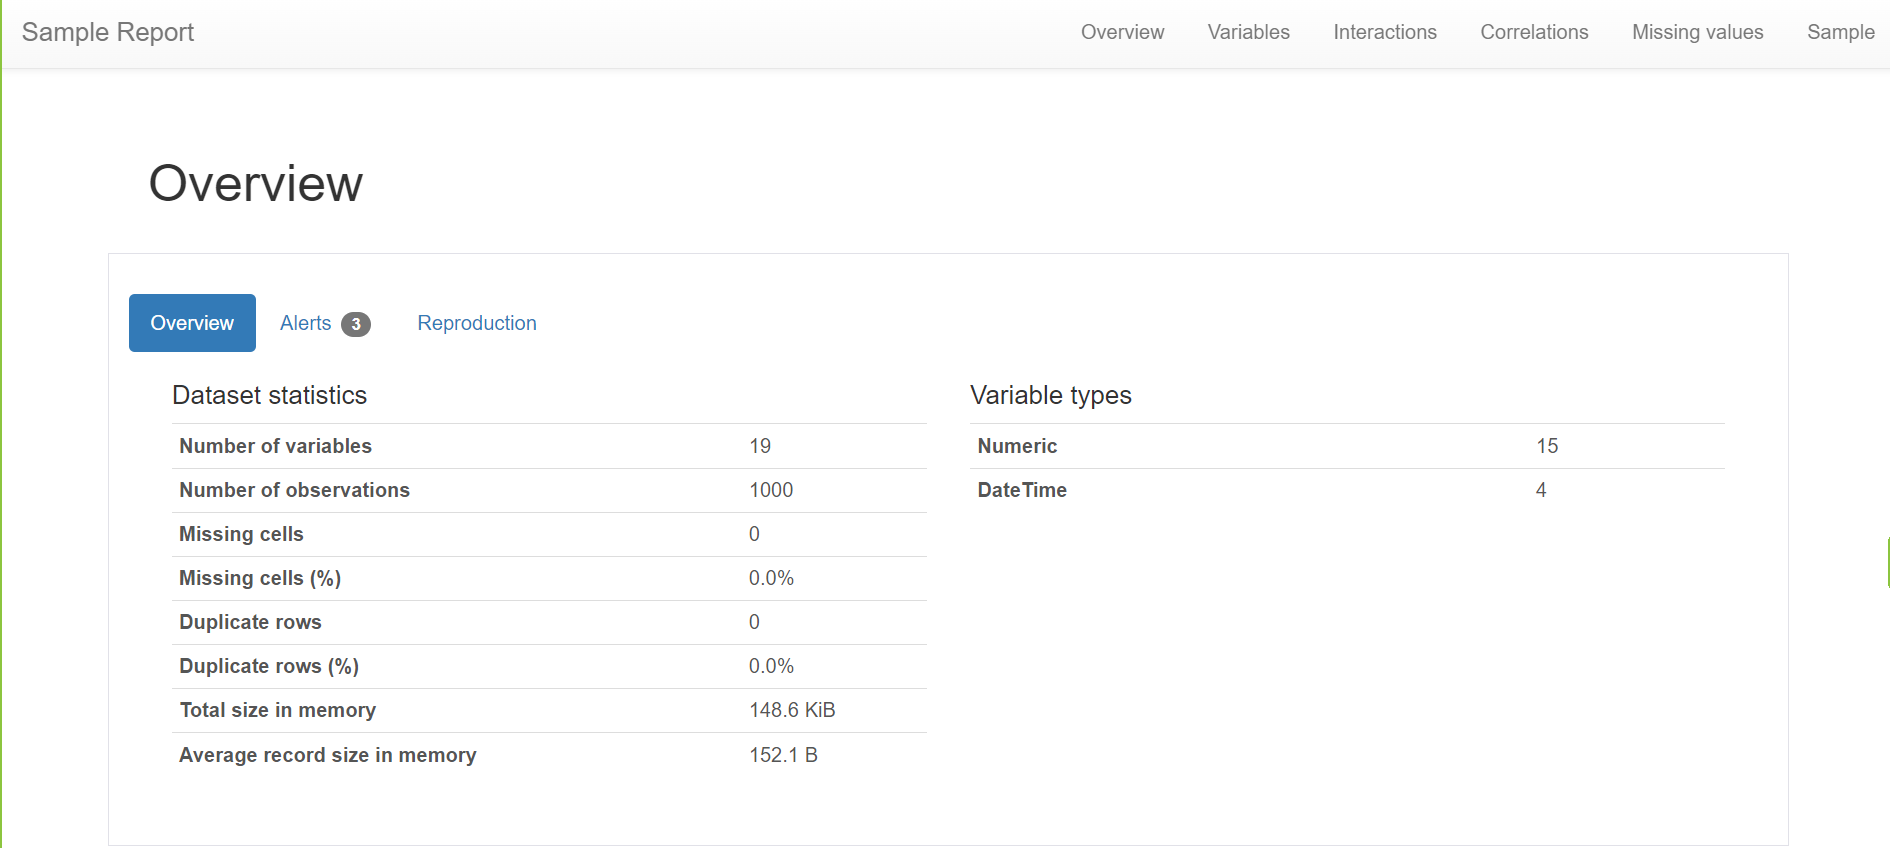



It can be seen that the data was taken from the right data source and as stated before, consistent of numerical data. No mssing cells or duplicate values were found either due to the sanitization process. The alerts however, show:

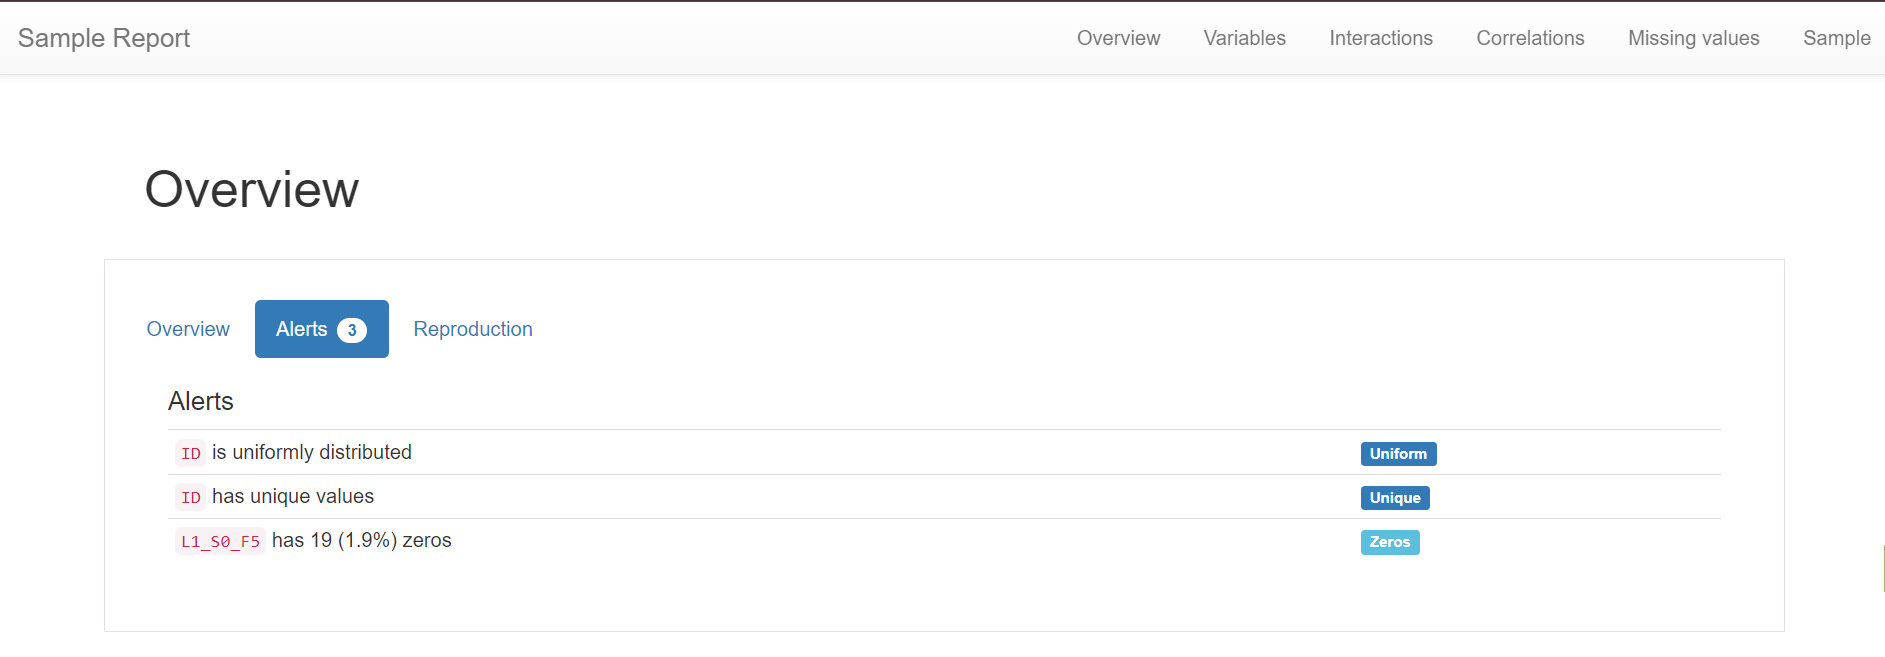

ID being uniformly distribuited is within the norm given is an identifier, thus by consequence must be unique; however,  the feature **F5** corresponding to the station **S0** and assambly line **L1** showing an alert for zeros in comparison to the other variables could indicate a problem within the production or ensamble process, the materials, sensors and actuators involved. Observing the details of the variable:

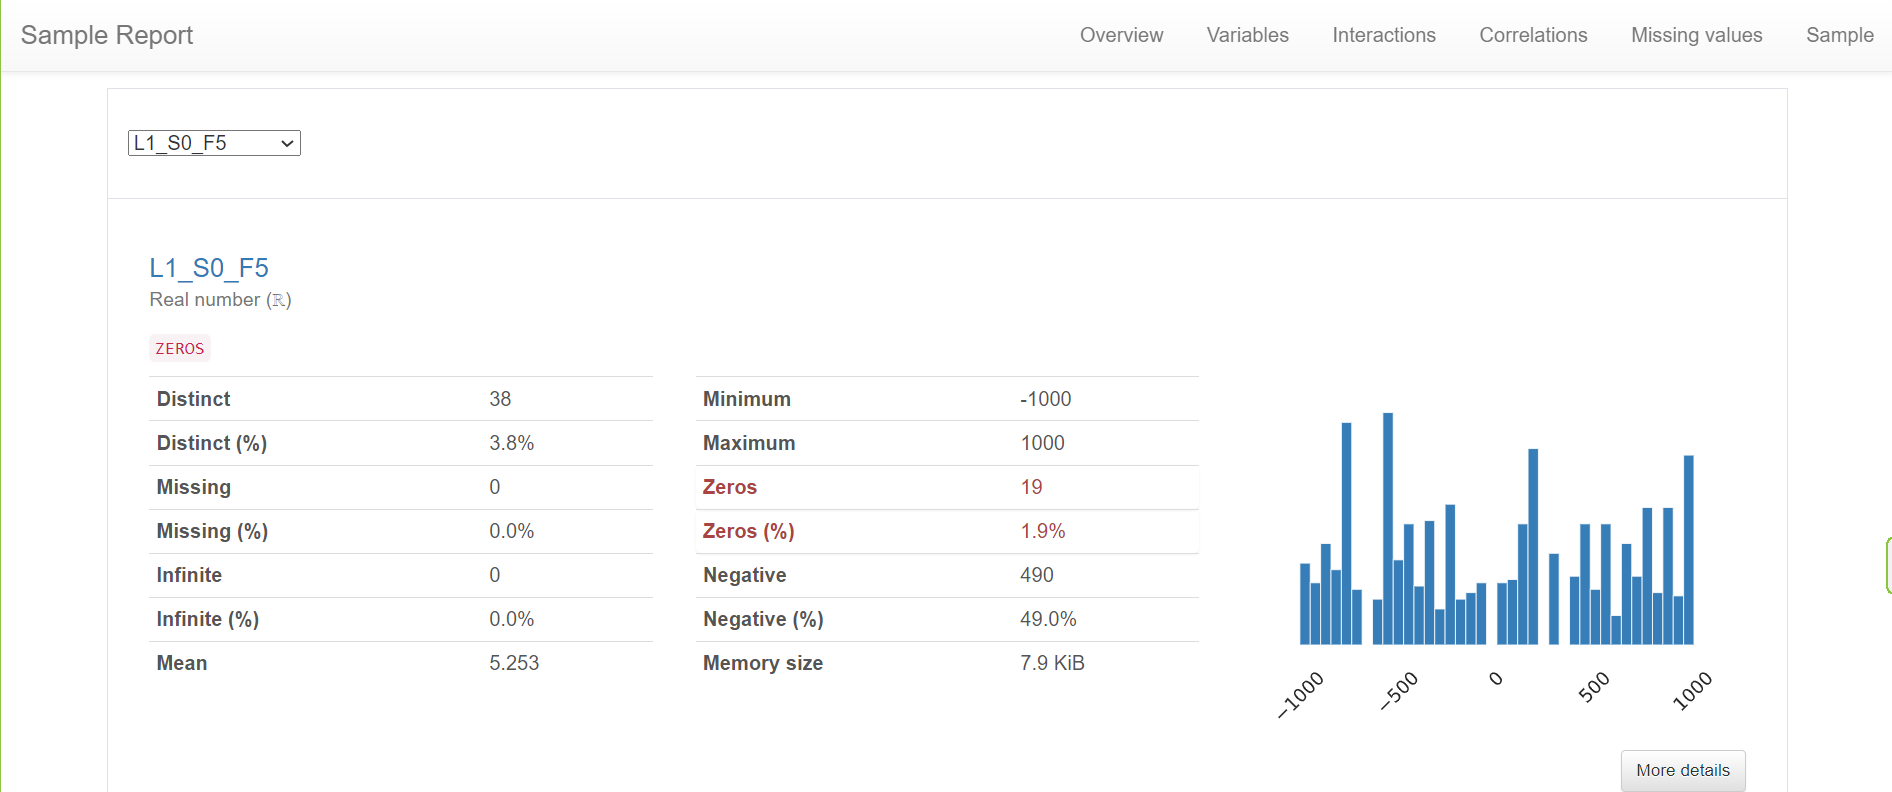

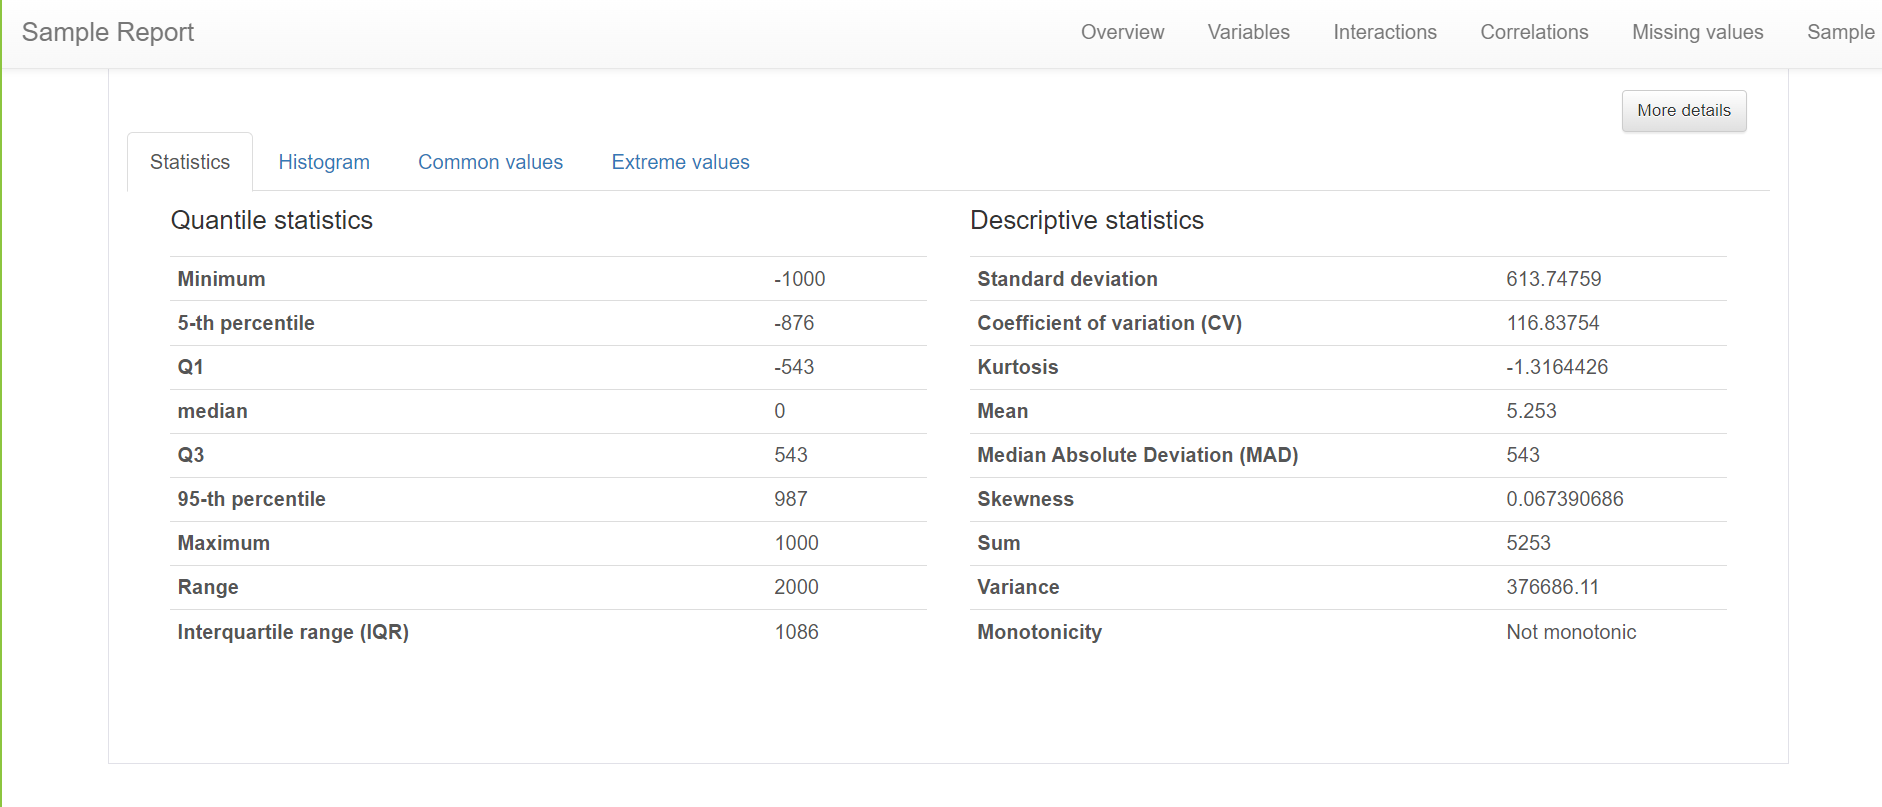

Quantile and descriptive statistics for the variable allow to examine the tendency of the data, in this case showing a negative skewness although minimal, which coupled with the alert and the previous analysis of the variables could mean the 19 records with zeroes represent a defect in the production process; given that the working station and asambly line of the other features do not exhibe the same behavior, it can be said the error ocurred due to the feature specifics:

In [102]:
# Subsetting to identify where the zeroes came from and detect a pattern
FeatureF5 = MockDF[["ID", "L1_S0_F5", "L1_S0_D8"]]

# Styling the date format to identify the recurrencies
FeatureF5.style.format({"DOB": lambda t: t.strftime("%m-%d-%Y")})
ZeroesF5 = FeatureF5.loc[FeatureF5['L1_S0_F5'] == 0]
ZeroesF5

,ID,L1_S0_F5,L1_S0_D8
1,2,0,8/19/2023
115,116,0,8/19/2023
176,177,0,10/23/2023
221,222,0,10/18/2023
230,231,0,3/26/2023
235,236,0,7/11/2023
367,368,0,3/25/2023
408,409,0,5/25/2023
418,419,0,8/11/2023
514,515,0,4/24/2023


from matplotlib import pyplot as plt
ZeroesF5['ID'].plot(kind='hist', bins=20, title='ID')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['ID']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'ID'}, axis=1)
              .sort_values('ID', ascending=True))
  xs = counted['ID']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = ZeroesF5.sort_values('ID', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ID')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['L1_S0_F5']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'L1_S0_F5'}, axis=1)
              .sort_values('L1_S0_F5', ascending=True))
  xs = counted['L1_S0_F5']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = ZeroesF5.sort_values('L1_S0_F5', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('L1_S0_F5')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
ZeroesF5['ID'].plot(kind='line', figsize=(8, 4), title='ID')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['ID'].plot(kind='hist', bins=20, title='ID')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='index', y='ID', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['ID']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'ID'}, axis=1)
              .sort_values('ID', ascending=True))
  xs = counted['ID']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('ID', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ID')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['L1_S0_F5']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'L1_S0_F5'}, axis=1)
              .sort_values('L1_S0_F5', ascending=True))
  xs = counted['L1_S0_F5']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('L1_S0_F5', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('L1_S0_F5')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_6['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['ID'].plot(kind='line', figsize=(8, 4), title='ID')
plt.gca().spines[['top', 'right']].set_visible(False)

To corroborate the count of zeroes per date distribution as shown above, the data can also be analized to count the number of records not belongin to a group:

In [134]:
# Counting groups and getting the description
ZeroesF5.L1_S0_D8.nunique()
ZeroesF5.L1_S0_D8.describe()

count            19
unique           18
top       8/19/2023
freq              2
Name: L1_S0_D8, dtype: object

By carefully observing the records of the 19 zeroes, only two happened in the same day, which given the size of the sample and the data distribution indicates that the error in the production margin could be within the allowed margin of operation; however, to optimize the error detection the incidents could be tracked with the timestamp within the system to determinate the cause, thus improving the current model to reduce costs and risks within the production quality metrics and the production assembly line performance.

